In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pyfolio as pf
from tqdm import tqdm 

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

/Users/chirkov.na/Library/Python/3.9/lib/python/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
df_pre = pd.read_csv('futures-pnls.csv') # Почасовые данные за 2011-12-01 - 2025-03-31
tickers = ['BPA', 'CAA', 'DAA', 'EUA', 'MXA', 'SFA', 'EP', 'NKD', 'VX']
df_pre['month_dt'] = pd.to_datetime(df_pre['Date']).dt.to_period('M')
df_pre['day_dt'] = pd.to_datetime(df_pre['Date']).dt.to_period('D')
df = df_pre[['Date', 'month_dt', 'day_dt']+tickers].copy() 

df_returns = df.copy()
df_returns[tickers] = df_returns[tickers].pct_change()
df_returns.head()

,Date,month_dt,day_dt,BPA,CAA,DAA,EUA,MXA,SFA,EP,NKD,VX
0,2011-12-01 00:00:00,2011-12,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-01 00:01:00,2011-12,2011-12-01,0.000029,-0.000023,-0.000013,0.000019,0.0,-0.000012,-0.000013,NaN,NaN
2,2011-12-01 00:02:00,2011-12,2011-12-01,0.000046,0.000000,0.000054,0.000060,0.0,0.000031,-0.000038,NaN,NaN
3,2011-12-01 00:03:00,2011-12,2011-12-01,0.000000,-0.000048,-0.000054,-0.000090,0.0,0.000031,-0.000075,NaN,NaN
4,2011-12-01 00:04:00,2011-12,2011-12-01,-0.000023,0.000000,0.000000,0.000060,0.0,0.000031,0.000000,NaN,NaN


In [4]:
for x in tickers:
    df[f'{x}_hit']=pd.notna(df[x]).astype('int')

df_hit = df.groupby("day_dt").agg(BPA_hit = pd.NamedAgg(column="BPA_hit", aggfunc="mean"), 
                                   CAA_hit = pd.NamedAgg(column="CAA_hit", aggfunc="mean"), 
                                   DAA_hit = pd.NamedAgg(column="DAA_hit", aggfunc="mean"), 
                                   EUA_hit = pd.NamedAgg(column="EUA_hit", aggfunc="mean"), 
                                   MXA_hit = pd.NamedAgg(column="MXA_hit", aggfunc="mean"), 
                                   SFA_hit = pd.NamedAgg(column="SFA_hit", aggfunc="mean"), 
                                   EP_hit = pd.NamedAgg(column="EP_hit", aggfunc="mean"), 
                                   NKD_hit = pd.NamedAgg(column="NKD_hit", aggfunc="mean"), 
                                   VX_hit = pd.NamedAgg(column="VX_hit", aggfunc="mean"))
df_hit.reset_index(inplace=True)
df_hit['day_dt'] = df_hit['day_dt'].map(str)

In [5]:
def plot_hit(ticker):
    fig, ax = plt.subplots(figsize=(20, 6))  
    plt.plot(df_hit['day_dt'], df_hit[f'{ticker}_hit'])
    ax.set_xlabel('Дни', fontsize=10)      
    ax.set_ylabel('Для ненуловых значений', fontsize=10)     
    ax.set_title(f'Динамика доли ненуловых значений для {ticker}', fontsize=15) 
    plt.xticks(np.arange(len(df_hit['day_dt']))[::61], df_hit['day_dt'][::61], rotation=90)
    ax.grid()
    ax.set_facecolor('white') 
    plt.show()

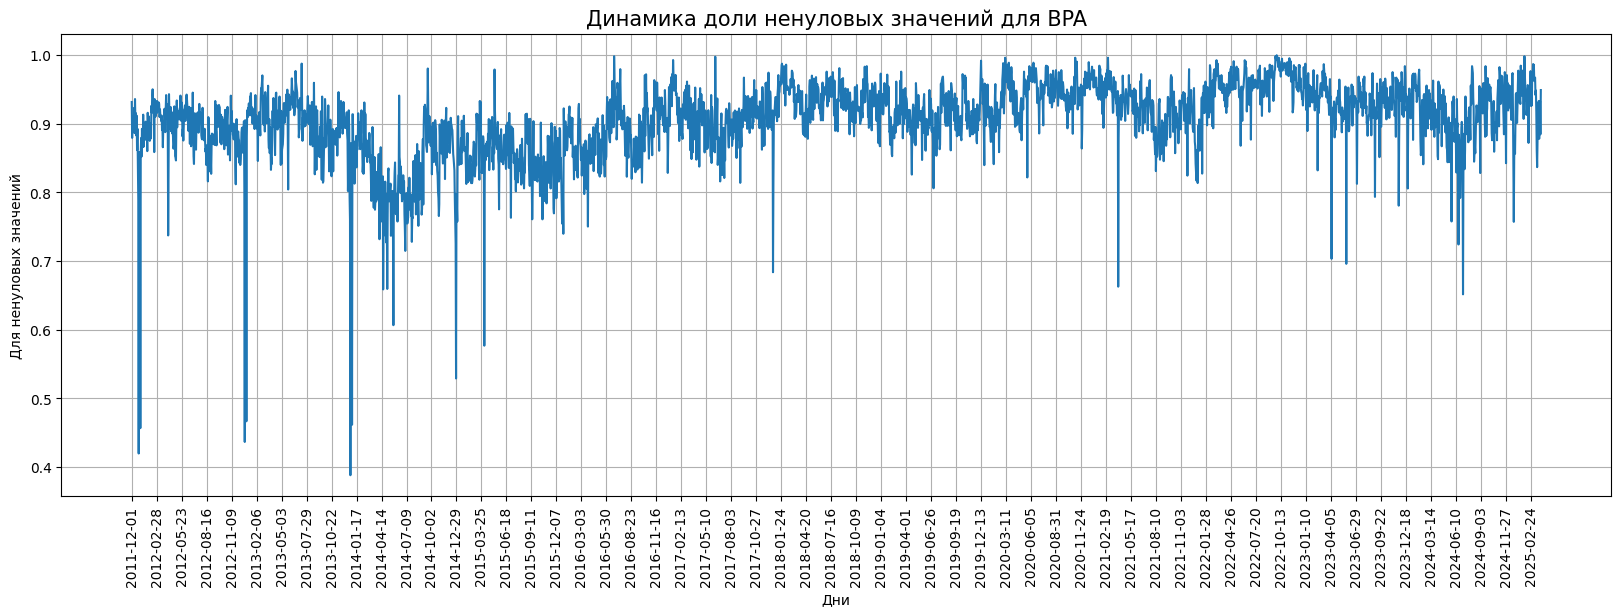

In [6]:
plot_hit('BPA')

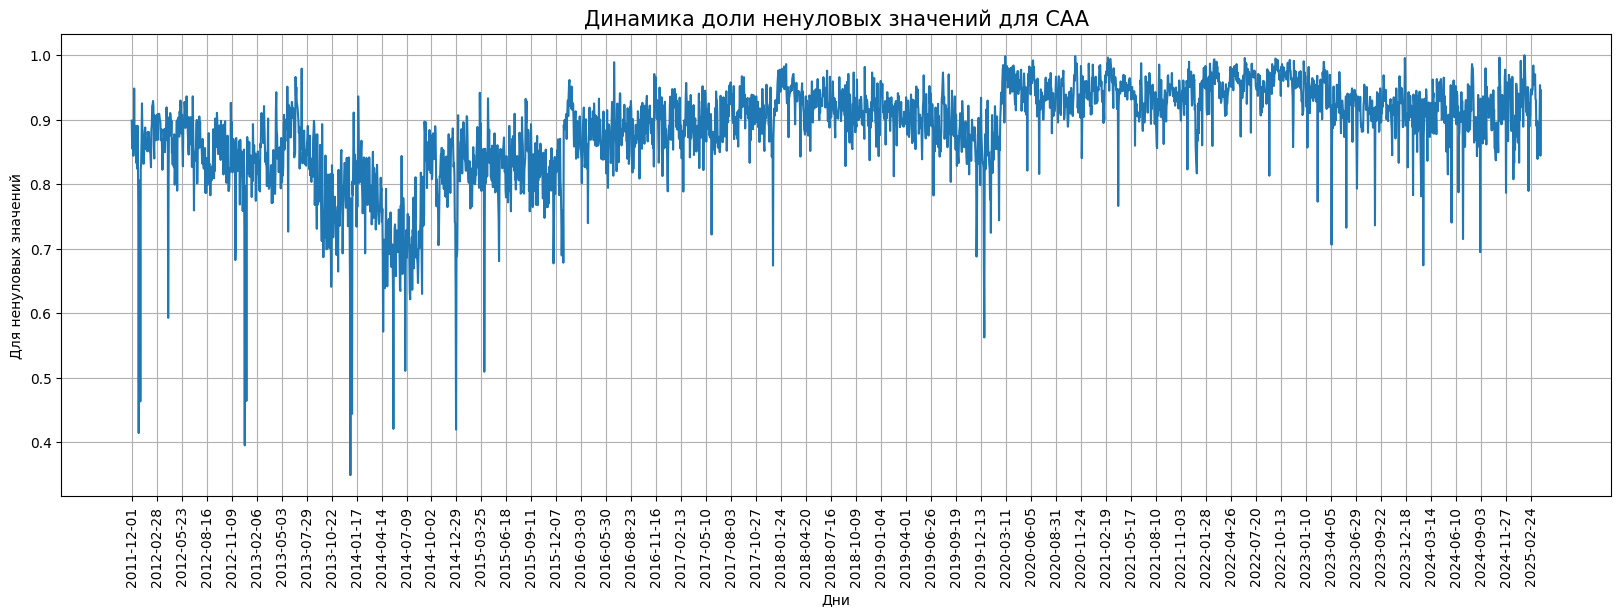

In [7]:
plot_hit('CAA')

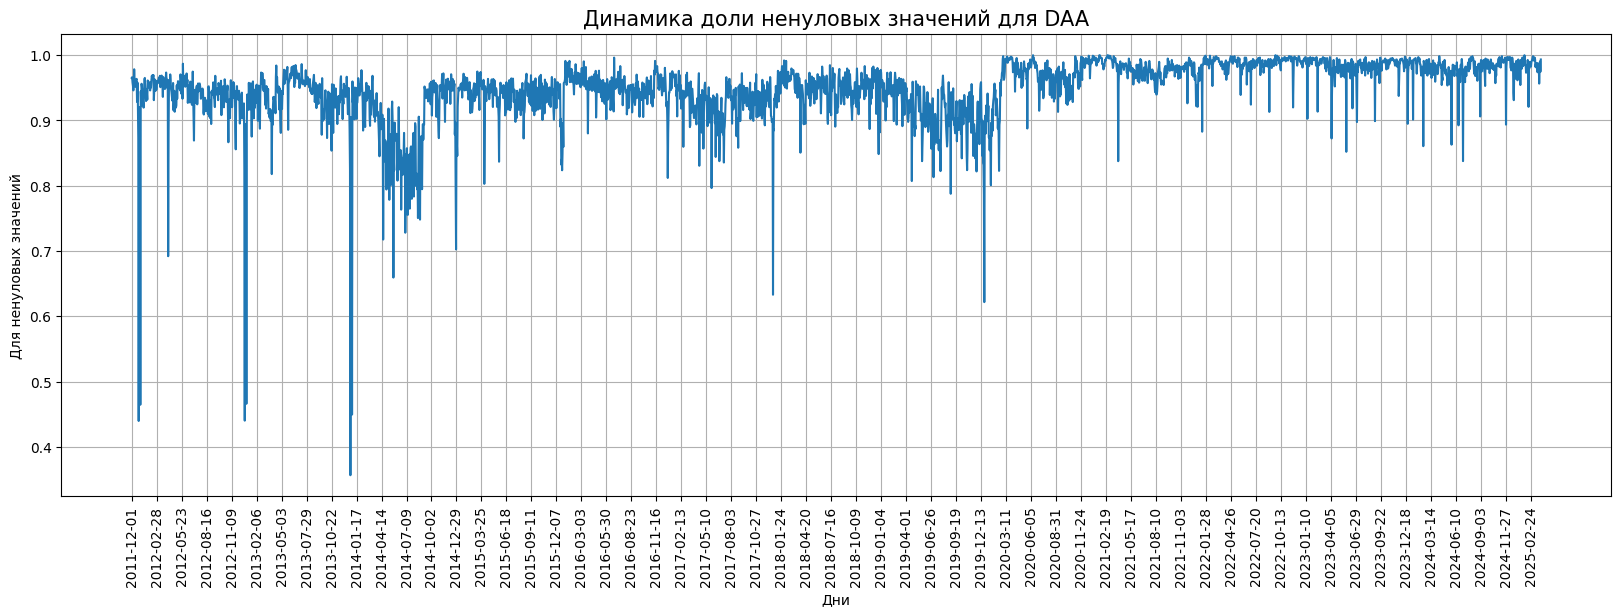

In [8]:
plot_hit('DAA')

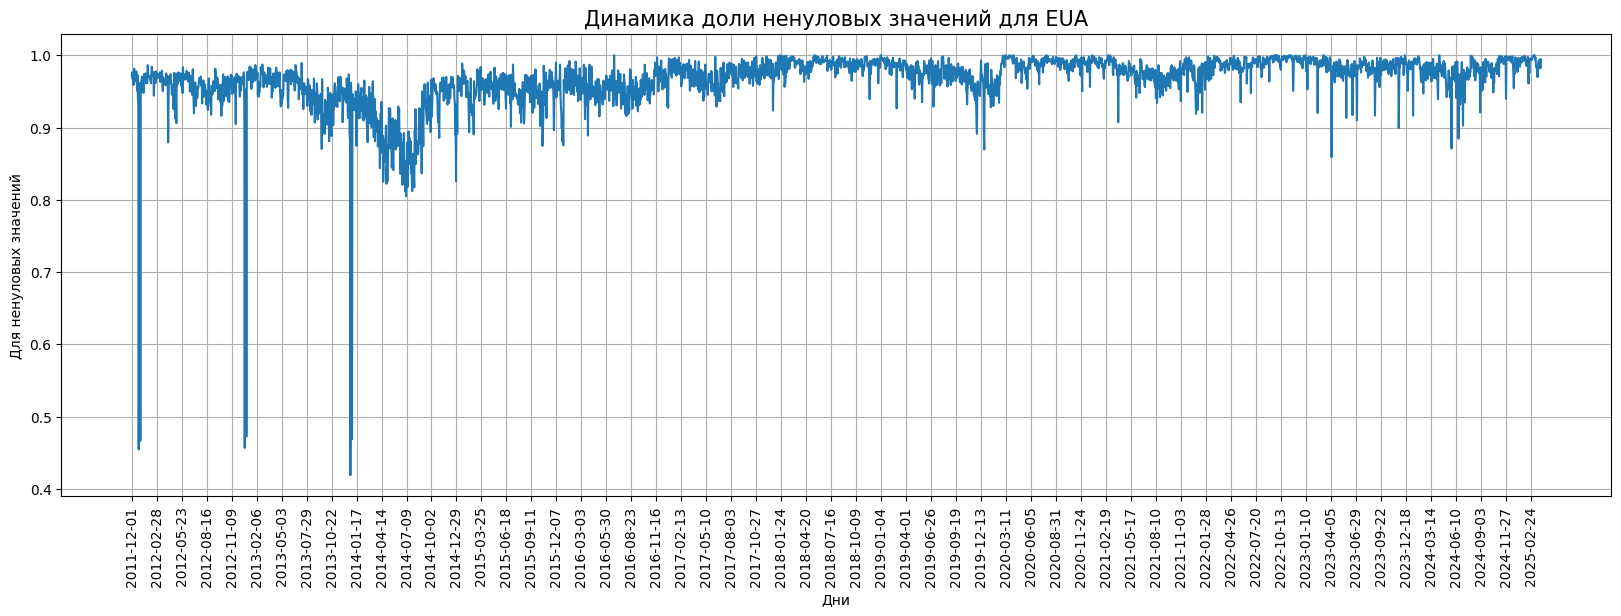

In [9]:
plot_hit('EUA')

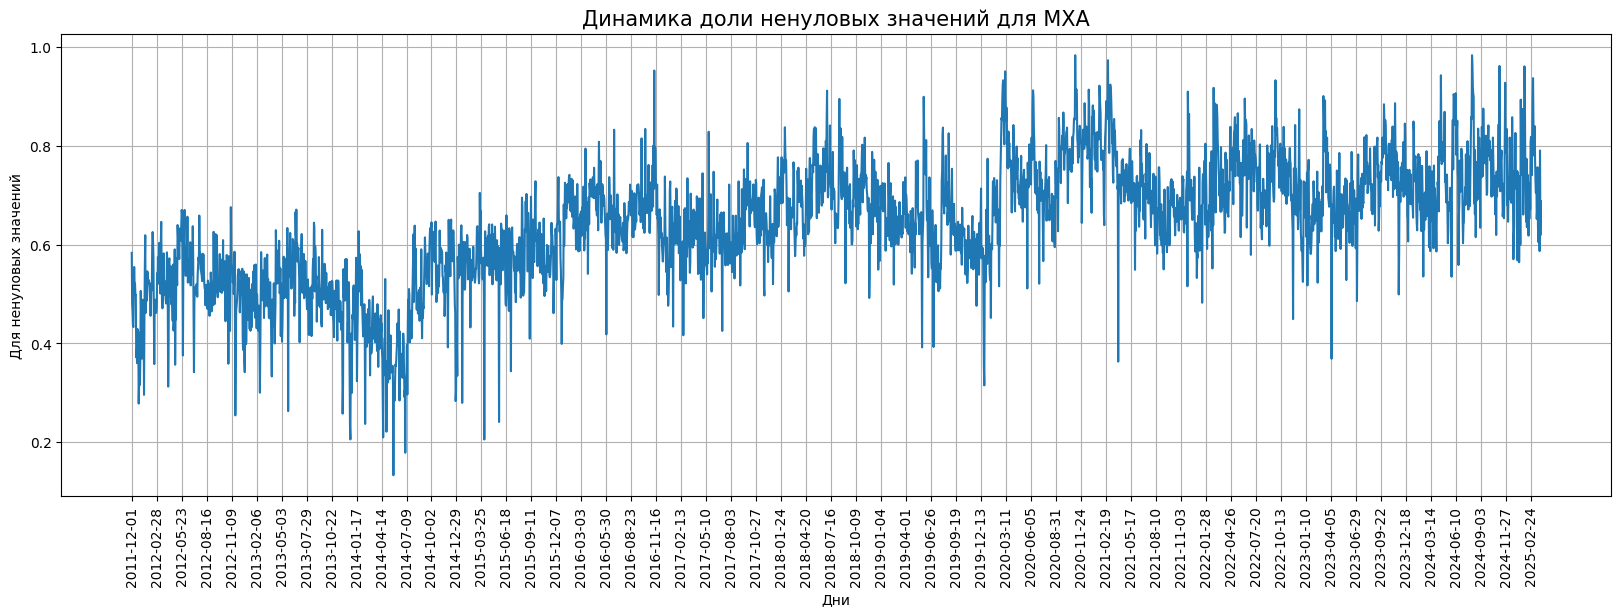

In [10]:
plot_hit('MXA')

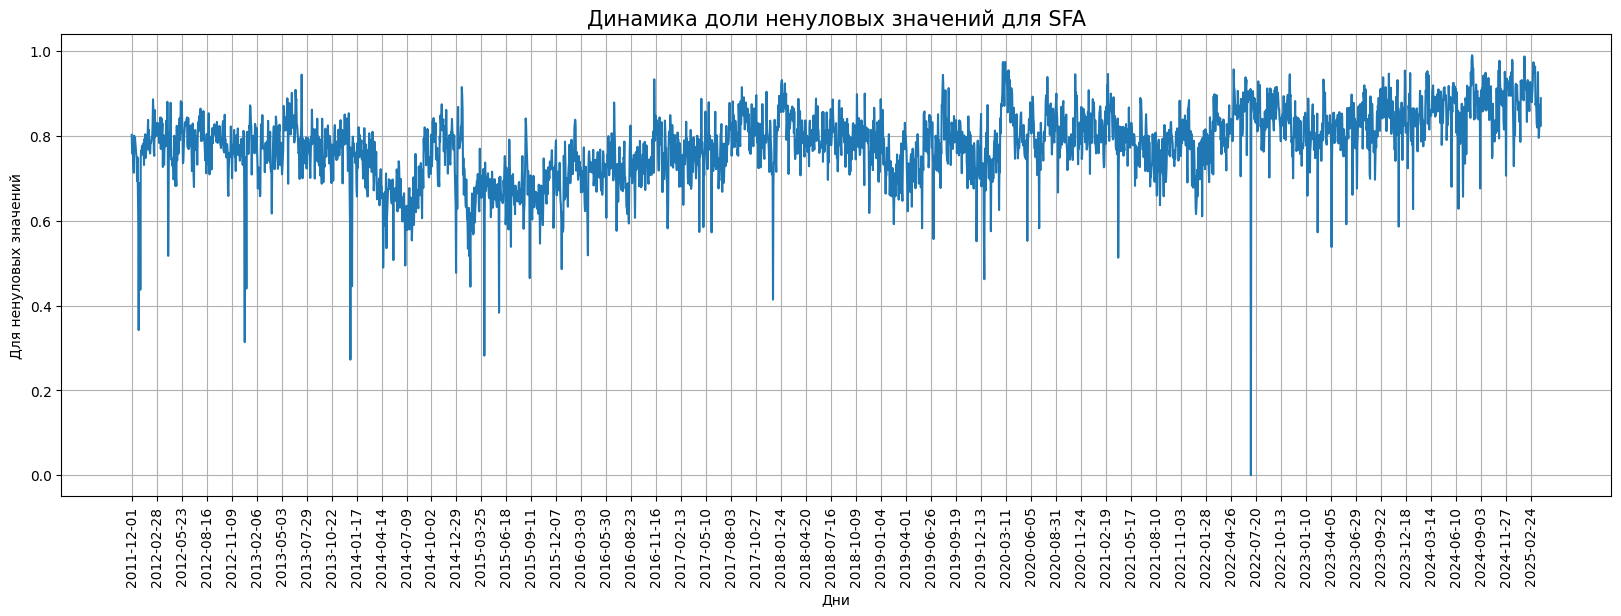

In [11]:
plot_hit('SFA')

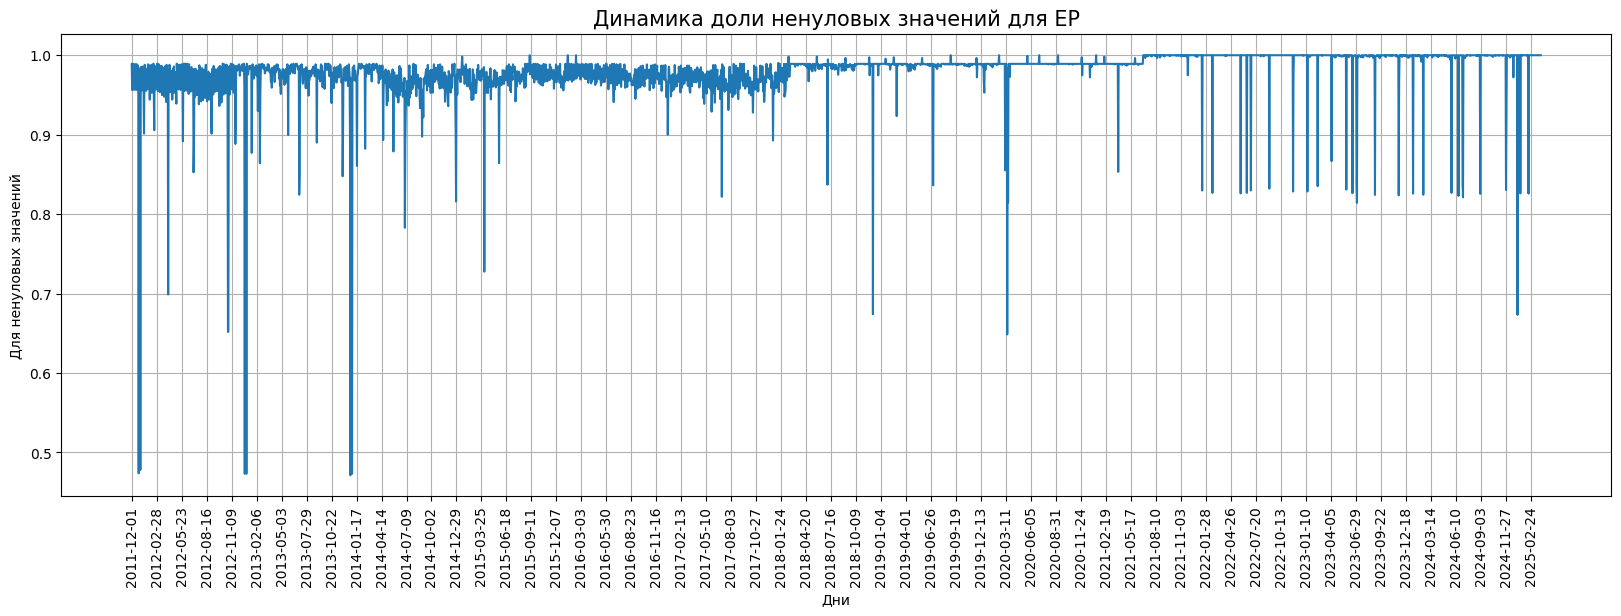

In [12]:
plot_hit('EP')

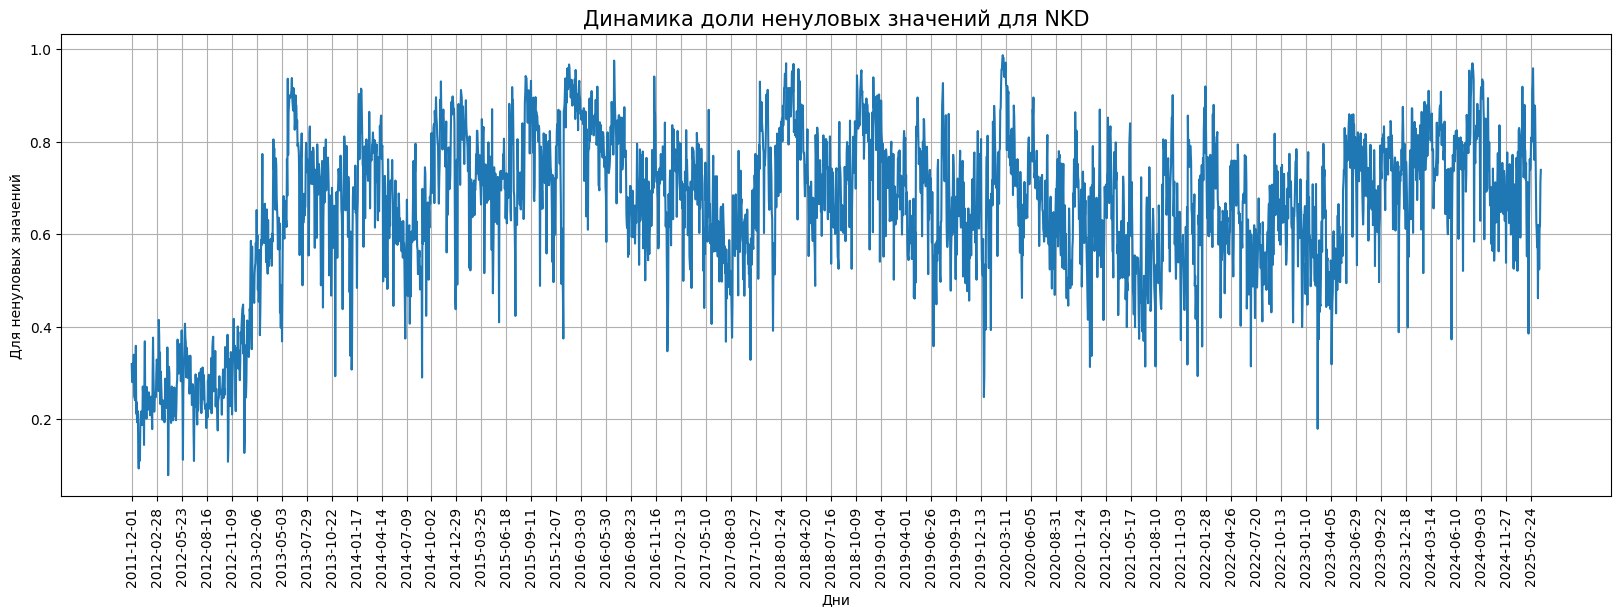

In [13]:
plot_hit('NKD')

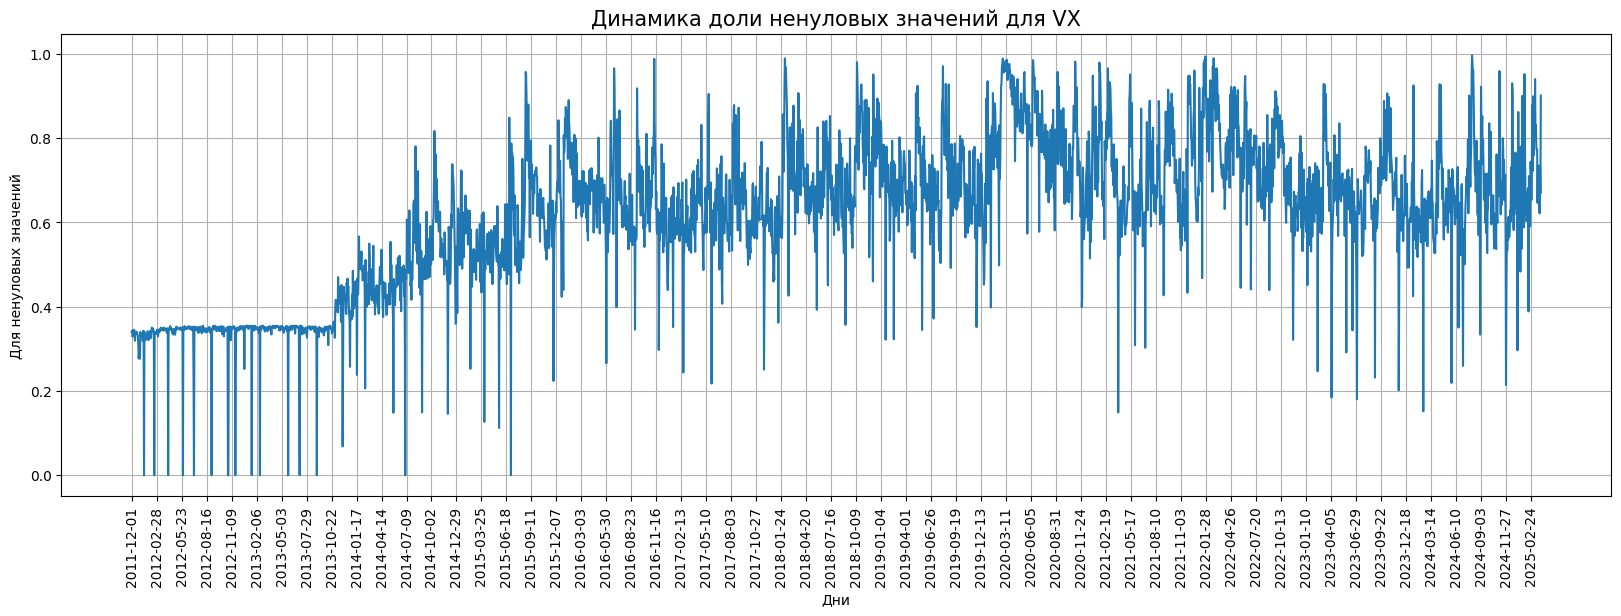

In [14]:
plot_hit('VX')

In [6]:
class markovitz_model:
    def __init__(self, df, tickers, risk_free_rate=0.0):
        self.df = df.copy()
        self.df['Date']=pd.to_datetime(self.df['Date'])
        self.risk_free_rate=risk_free_rate
        self.tickers=tickers
    
    def calc_sharpe_ratio(self, weights, returns_vector, cov_matrix):
        total_return = weights @ returns_vector
        total_volat = np.sqrt(weights.T @ cov_matrix @ weights)
        return (total_return - self.risk_free_rate) / total_volat
    
    def step(self, returns_vector, cov_matrix, metric, weights_sum=1):
        weights = np.array([1/len(returns_vector) for _ in range(len(returns_vector))])

        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights)-weights_sum},  
            {'type': 'ineq', 'fun': lambda weights: weights} 
        )
        bounds = tuple((0, 1) for _ in range(len(returns_vector)))

        if metric == 'sharpe_ratio':
            result = minimize(fun =lambda weights: -self.calc_sharpe_ratio(weights=weights, returns_vector=returns_vector, cov_matrix=cov_matrix), x0=weights, method='SLSQP', bounds=bounds, constraints=constraints)
        elif metric == 'return':
            result = minimize(fun = lambda weights: -weights @ returns_vector, x0=weights, method='SLSQP', bounds=bounds, constraints=constraints)
        elif metric == 'volatility':
            result = minimize(fun = lambda weights: np.sqrt(weights @ cov_matrix @ weights), x0=weights, method='SLSQP', bounds=bounds, constraints=constraints)

        return result
    
    def make_strategy(self, window_size=30, start_date = '2013-01-01', periods=365, metric='sharpe_ratio'):
        current_date = pd.to_datetime(start_date) + timedelta(days=1)
        dates_list = [pd.to_datetime(start_date)] 
        weights_list = [np.ones(len(self.tickers))/len(self.tickers)]
        portfolio_returns_list = [(self.df[self.df['Date']==current_date][tickers].values @ np.ones(len(self.tickers))/len(self.tickers))[0]]

        for i in tqdm(range(periods)):
            window_start, window_end = current_date - timedelta(days=window_size), current_date

            # Если такой даты нет в датасете (выходной / праздник), то не ребалансируемся в этот день
            if len(self.df[self.df['Date']==current_date])==0:
                dates_list.append(current_date)
                weights_list.append(weights_list[-1])
                portfolio_returns_list.append(portfolio_returns_list[-1])
            else:  
                # Ищем веса только для тех фьючерсов, у которых ненуловая цена в этот день
                not_null_mask = pd.notna(self.df[self.df['Date']==current_date][tickers]).values[0]
                not_null_tickers = []
                current_weights_sum = 0
                for i in range(len(self.tickers)):
                    if not_null_mask[i]==True:
                        not_null_tickers.append(tickers[i])
                        # Если фьючерс имеет ненулевую цену, прибавляем его вес с прошлого шага в общую сумму весов, доступную к ребалансировке на данном шаге
                        current_weights_sum +=weights_list[-1][i]

                returns_vector = self.df[not_null_tickers][(self.df['Date']>=window_start) & (self.df['Date']<=window_end)].mean().values
                cov_matrix = self.df[not_null_tickers][(self.df['Date']>=window_start) & (self.df['Date']<=window_end)].cov().values
                step_result = self.step(returns_vector=returns_vector, cov_matrix=cov_matrix, metric=metric, weights_sum=current_weights_sum)

                # Если оптимизация завершилась успехом, то обновляем веса и доходность портфеля
                if step_result.success==True: 
                    current_weights = step_result.x
                    current_portfolio_return = (self.df[self.df['Date']==current_date][not_null_tickers].values @ current_weights)[0]
                    dates_list.append(current_date)
                    weights_list.append(current_weights)
                    portfolio_returns_list.append(current_portfolio_return)

                # Если оптимизация не удалась, то не ребалансируемся в этот день
                else:
                    dates_list.append(current_date)
                    weights_list.append(weights_list[-1])
                    portfolio_returns_list.append(portfolio_returns_list[-1])
            current_date += timedelta(days=1)
        return pd.DataFrame.from_dict({'dates': dates_list, 'weights': weights_list, 'portfolio_returns': portfolio_returns_list})
        

In [24]:
model = markovitz_model(df=df_returns, tickers = tickers)
df_result = model.make_strategy(periods = 4472)
df_result.set_index('dates', inplace=True)
df_result.to_csv('markovitz_result.csv', index=False)

100%|██████████| 4472/4472 [03:58<00:00, 18.76it/s]


Start date,2013-01-01
End date,2025-03-31
Total months,213
,Backtest
Annual return,0.088%
Cumulative returns,1.566%
Annual volatility,0.349%
Sharpe ratio,0.25
Calmar ratio,0.04
Stability,0.47
Max drawdown,-2.332%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.33,2013-01-06,2017-08-21,2020-03-02,1866
1,0.63,2021-03-14,2022-03-24,NaT,NaN
2,0.51,2020-04-29,2020-07-12,2021-03-14,228
3,0.26,2020-03-23,2020-03-24,2020-04-17,20
4,0.18,2020-03-18,2020-03-22,2020-03-23,4


/Users/chirkov.na/Library/Python/3.9/lib/python/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


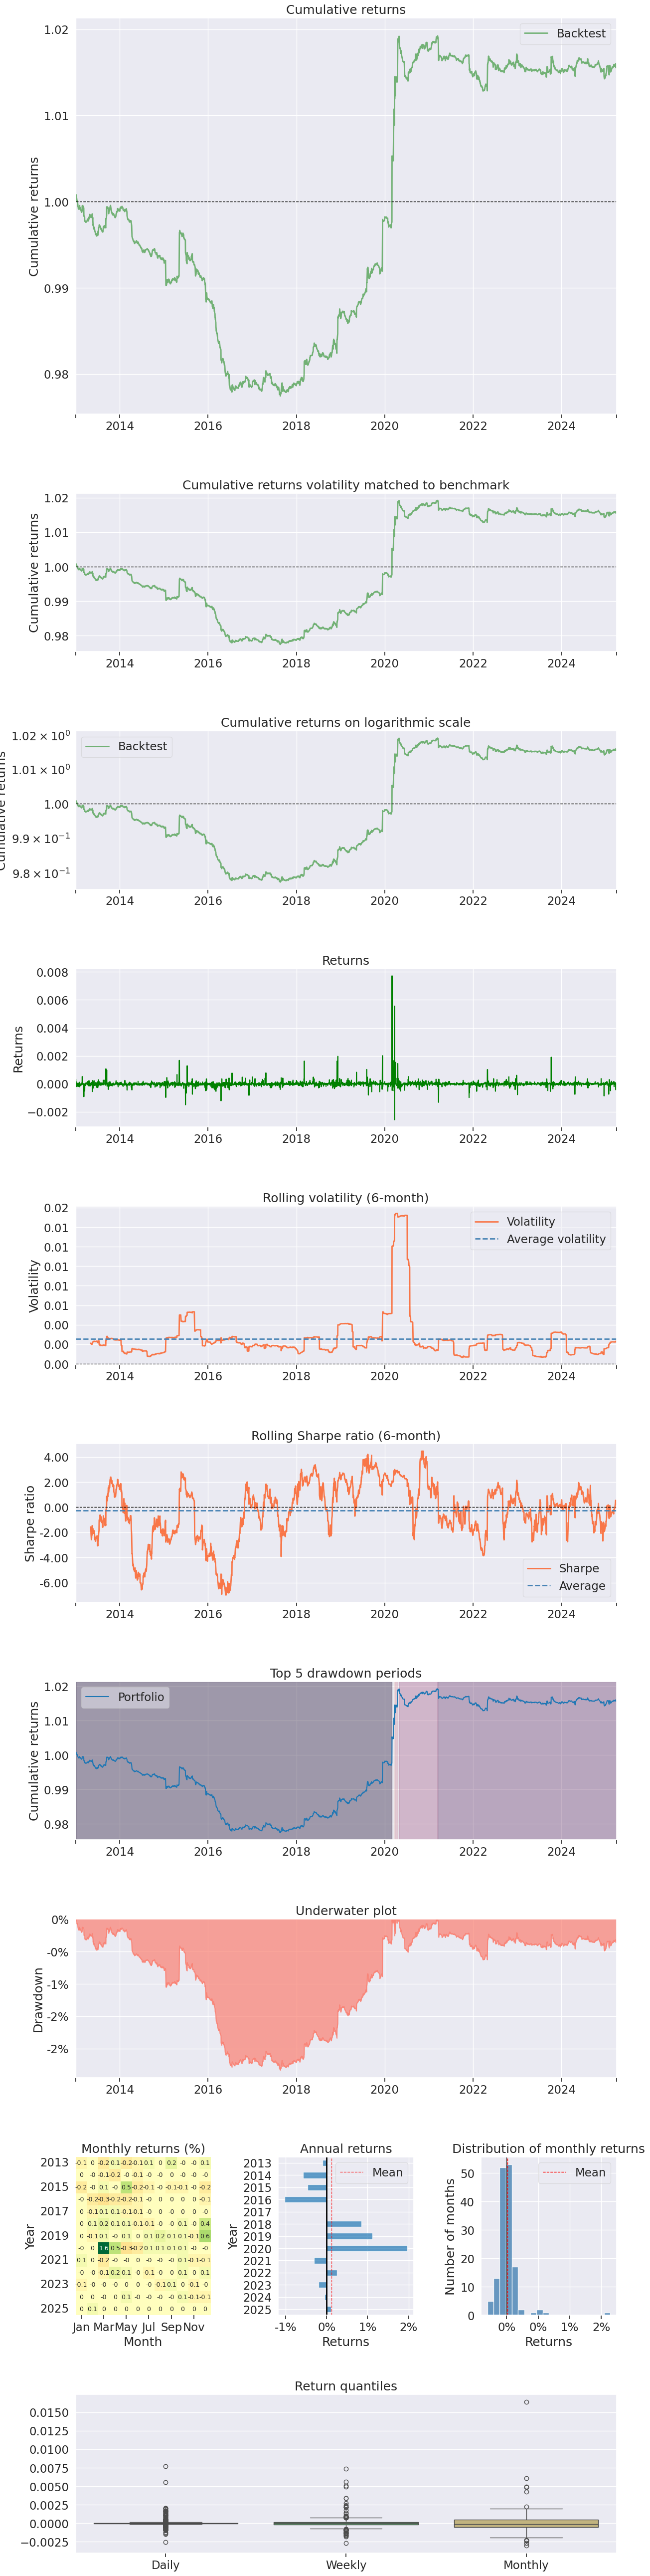

In [ ]:
pf.create_returns_tear_sheet(returns = df_result['portfolio_returns'])